Reward: 21.000000
(1000, 2)


<IPython.core.display.Javascript object>


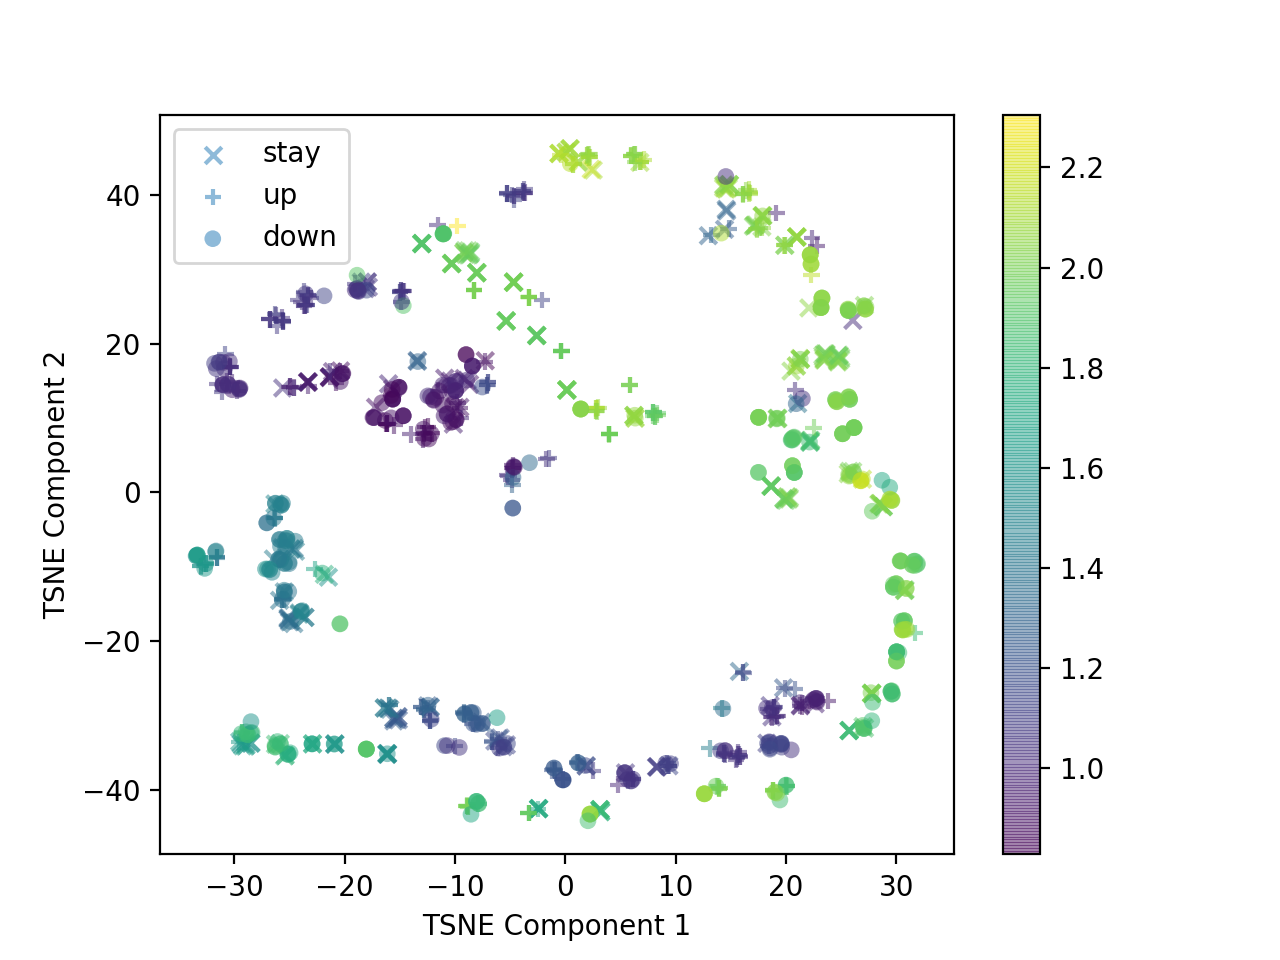

In [1]:
from Wrapper.layers import *
from Wrapper.wrappers import make_atari, wrap_deepmind, wrap_pytorch
import math, random
import gym
import json
import numpy as np
from collections import deque
import math, random
import matplotlib
%matplotlib notebook
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
USE_CUDA = torch.cuda.is_available()
from NEWdqn import QLearner, compute_td_loss, ReplayBuffer
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import seaborn as sns
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

class SampleBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done, img):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done, img))

    def sample(self, batch_size):

        state, action, reward, next_state, done, img = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done, img

    def __len__(self):
        return len(self.buffer)

'''
def plots(frame_idx, rewards, losses):
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.title('Frame %s. Last-10 reward: %s' % (frame_idx, np.mean(rewards[-10:], 0)[1]))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.savefig("plots/plot-frame-{}.png".format(frame_idx))
'''
env_id = "PongNoFrameskip-v4"
env = make_atari(env_id)
env = wrap_deepmind(env)
env = wrap_pytorch(env)

num_frames = 3000000
batch_size = 32
gamma = 0.99
record_idx = 10000

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)
model = QLearner(env, num_frames, batch_size, gamma, replay_buffer)
model.load_state_dict(torch.load("model-3000000.pth", map_location=torch.device('cpu')))

samp_buffer = SampleBuffer(100000)
# New code for second model
#target_model = QLearner(env, num_frames, batch_size, gamma, replay_buffer)
#target_model.copy_from(model)

optimizer = optim.Adam(model.parameters(), lr=0.00001)
if USE_CUDA:
    model = model.cuda()
# New code     
    #target_model = target_model.cuda()
    #print("Using cuda")

# Epsilon is the chance of making a random move
# It trades of exploration vs exploitation
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()

while True:
    #print("Frame: " + str(frame_idx))

    #epsilon = epsilon_by_frame(frame_idx)
    epsilon = 0
    # Perform an action based on current state and epsilon
    action = model.act(state, epsilon)
    x = env.render(mode='rgb_array')
    next_state, reward, done, _ = env.step(action)
    
    # Push <s, a, r, s'> t the replay buffer
    replay_buffer.push(state, action, reward, next_state, done)
    samp_buffer.push(state, action, reward, next_state, done, x)

    # store the new state and the cummulative reward for the game
    state = next_state
    episode_reward += reward

    # game is over
    if done:
        print('Reward: %f' % episode_reward)
        all_rewards.append(episode_reward)
        episode_reward = 0
        break
        
    #    state = env.reset()
    #    all_rewards.append((frame_idx, episode_reward))
    #    episode_reward = 0

    # replay buffer is big enough
    #if len(replay_buffer) > replay_initial:
        #New Code
    #    loss = compute_td_loss(model, target_model, batch_size, gamma, replay_buffer)
    #    optimizer.zero_grad()
    #    loss.backward()
    #    optimizer.step()
    #    losses.append((frame_idx, loss.data.cpu().numpy()[()]))
        #print(loss.data, type(loss.data.cpu().numpy()), loss.data.cpu().numpy().shape, loss.data.cpu().numpy(), loss.data.cpu().numpy().tolist())

    #if frame_idx % 10000 == 0 and len(replay_buffer) <= replay_initial:
    #    print('#Frame: %d, preparing replay buffer' % frame_idx)

    #if frame_idx % 10000 == 0 and len(replay_buffer) > replay_initial:
    #    print('#Frame: %d, Loss: %f' % (frame_idx, np.mean(losses, 0)[1]))
    #    print('Last-10 average reward: %f' % np.mean(all_rewards[-10:], 0)[1])

    # New code
    #if frame_idx % 50000 == 0:
    #    target_model.copy_from(model)

    #if frame_idx >= 2000000 and frame_idx % 10000 == 0:
    #    torch.save(model.state_dict(), "models/model-{}.pth".format(frame_idx))
        #torch.save(target_model.state_dict(), "models/targetmodel-{}.pth".format(frame_idx))
    #    print("Model saved at frame {}".format(frame_idx))

state_samp, action_samp, reward_samp, next_state_samp, done_samp, x_samp = samp_buffer.sample(1000)

state_samp = Variable(torch.FloatTensor(np.float32(state_samp)))
next_state_samp = Variable(torch.FloatTensor(np.float32(next_state_samp)), requires_grad=True)
action_samp = Variable(torch.LongTensor(action_samp))
reward_samp = Variable(torch.FloatTensor(reward_samp))
done_samp = Variable(torch.FloatTensor(done_samp))

action_samp = action_samp.numpy()

action_samp[action_samp==1] = 0
action_samp[action_samp==4] = 2
action_samp[action_samp==5] = 3
#action_samp = action_samp.reshape(-1,1)

#cdict = {0: 'red', 2: 'blue', 3: 'green'}
# action_nam = action_samp.astype(str)

# action_nam[action_nam=='0'] = 'x'
# action_nam[action_nam=='2'] = '+'
# action_nam[action_nam=='3'] = 'o'

# mdict = {'x': 'stay', '+': 'up', 'o': 'down'}

cur = model.features(state_samp)
cur = cur.view(cur.size(0), -1)
qval = model.fc(cur)
cur = model.fc[0](cur)


cur = cur.detach().numpy()
qval = qval.detach().numpy()

qval_max = qval.max(axis=1)

reduction = TSNE(2)

red_result = reduction.fit_transform(cur)

print(red_result.shape)

# fig = plt.figure(figsize=(30,5))
# ax = fig.add_subplot(111)

# for g in np.unique(action_samp):
#     ix = np.where(action_samp == g)
#     ax.scatter(red_result[:,0][ix], red_result[:,1][ix], c = cdict[g], label = g, s = 100)
# ax.legend()
# plt.show()

stays = red_result[action_samp==0]
ups = red_result[action_samp==2]
downs = red_result[action_samp==3]
q_stays = qval_max[action_samp==0]
q_ups = qval_max[action_samp==2]
q_downs = qval_max[action_samp==3]

vmin, vmax = np.amin(qval_max), np.amax(qval_max)

plt.scatter(stays[:, 0], stays[:, 1],
            c=q_stays, vmin=vmin, vmax=vmax, edgecolor='none', alpha=0.5, marker='x', label='stay')

plt.scatter(ups[:, 0], ups[:, 1],
            c=q_ups, vmin=vmin, vmax=vmax, edgecolor='none', alpha=0.5, marker='+', label='up')

plt.scatter(downs[:, 0], downs[:, 1],
            c=q_downs, vmin=vmin, vmax=vmax, edgecolor='none', alpha=0.5, marker='o', label='down')

plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend()
plt.colorbar()
plt.savefig("tsne_plot.png")
plt.show()

In [2]:
def sampleslice(a, xmin, xmax, ymin, ymax):
    return np.where((a[:,0] >= xmin) & (a[:,0] <= xmax) & (a[:,1] >= ymin) & (a[:,1] <= ymax))[0]

In [6]:
purples = sampleslice(red_result, -18.11, -6.33, 5.6, 19.67)
blues = sampleslice(red_result, -34.24, -19.74, -18.7, -0.21)
yellows = sampleslice(red_result, -1.25, 7.26, 42.51, 47.08)

In [67]:
print(yellows[action_samp[yellows] == 0])
print(action_samp[yellows])
x_samp = np.array(x_samp)
#x_to_show = x_samp[purples[action_samp[purples] == 0]]
#print(x_to_show)

[286 431 477 488 547 579 665 717 733 752 758 935 986]
[2 3 2 2 2 2 0 2 2 0 2 2 0 2 0 2 2 0 0 2 2 2 0 0 0 0 0 2 2 2 2 0 2 2 0]


In [71]:
print(qval_max[547])


2.111949
